<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/ee-wq-lasso/blob/main/notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Notebook Authors: Anna Cardall and Gustavious Williams*, Brigham Young University

🚨 Please use the following citation for this notebook:

Cardall, A. C., Hales, R. C., Williams, G.P., Tanner, K. B., Markert, Kel N. (2023). LASSO (L1) Regularization for Development of Sparse Remtoe Sensing Models with Applications to Optically Complex Waters using GEE Tools. Remote Sensing.

</br>

## **Introduction**

Remote sensing data are commonly used to monitor water quality parameters such as clarity, temperature, and chlorophyll-a (chl-a) by collecting in situ data at the same time as satellite data and creating empirical models using methods like multi-linear or step-wise linear regression. However, these methods may not be effective for optically complex waters, which have interference from substances like suspended solids or dissolved organic matter that can "confuse" the model. In these cases, it may be useful to include non-standard terms that would not be considered using traditional methods. Machine learning has been successful in generating accurate empirical models without the need for parameter selection, but these models are not explainable due to the large number of included terms. 

This notebook uses Least Absolute Shrinkage and Select Operator (LASSO), or L1, regularization to fit linear regression models and create parsimonious models with a limited number of terms that can be interpreted and explained. It takes a CSV file of pairs of in-situ measurements and the associated remotely-sensed data and generates an L1-regularized linear model of a water quality parameter. This notebook references Landsat bands but may be modified for other satellites and sensors. **Please review the journal article associated with this notebook** for an in-depth treatment of the use and limitations of LASSO for developing remote sesning models.

We report model error using repeated k-fold cross-validation. You may specify the number of splits and repeats, and the results will report the average train and test RMSE. We include more information about repeated k-folds below. </br></br>

**Assumptions**
*  The remote sensing data contains good quality data (i.e., no clouds, cloud shadows, or land)
*  All samples in time and space may be used for training & testing
*  All desired data cleaning has been previously performed (ex. any unreasonably high, low, or physically impossible values have be removed from the dataset).

## **Instructions**

Obtaining the dataset requires fives steps:
1. Import packages
2. Prepare and import the set of data pairs 
3. Make some selections
4. Click 'Run' on a group of cells
5. Export results

Each step has its own heading and detailed instructions below.</br>

This tool does not require any programming, but some understanding of the code might be helpful if you would like to make adjustments or additions. If you are new to Python programming, go through [this guide](https://docs.python.org/3/tutorial/index.html).

## **1. Imports & Setup**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import itertools as it
from google.colab import files
import io
from scipy.sparse.compressed import csr_column_index2
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# allows all outputs to appear instead of last only
%config InteractiveShell.ast_node_interactivity = 'all'

## **2. Load in the dataset**

Load run the following cell and click the "Choose Files" button. Navigate to the file containing the data pairs of *in situ* and remotely-sensed data. If you haven't produced this file yet, try [this notebook](https://colab.research.google.com/drive/1gVjcYdx0EifIVpyws4ffGSC-9mXJtWj5?usp=sharing) for a tool or a reference method (there will be minimal debugging involved if this notebook is used!). The file should contain the following columns and column names (assuming you are using Landsat data):


</br>

| Column Name        | Format     | Example    
| ------------------ | ---------- | ----------- 
| parameter name     |            | chlorophyll-*a* 
| measurement value  |            | 31.8
| time window        | hours      | 2.144
| blue               |            | 0.128
| green              |            | 
| red                |            | 
| NIR                |            | 
| SWIR1              |            | 
| SWIR2              |            | 
| SurfTempK          |            | 

In [ ]:
uploaded = files.upload()
file_name_1 = list(uploaded.keys())[0]

df = pd.read_csv(io.BytesIO(uploaded[file_name_1]))

## **3. Make selections**

In [ ]:
#@markdown ### **Time window**
#@markdown Enter a coincidence tolerance in hours. This controls how many hours
#@markdown (on either side) of the in-situ sample collection date to check for 
#@markdown remotely-sensed data. [Hansen and Williams](https://www.mdpi.com/2306-5338/5/4/62) 
#@markdown recomend no more than 3 days. The paper associated with this notebook recomends 24 hours.

time_window = 13 #@param {type:"slider", min:0, max:120, step:1}
time_window = float(time_window)

#@markdown </br>


#------------------------------------------------------------------------------------------------

#@markdown ### **Prediction type**
#@markdown Check the box if you would like to predict the natural log of your 
#@markdown parameter (i.e. $ln(\text{chl-a})$).

log_prediction = False #@param {type:"boolean"}

#@markdown </br>


#------------------------------------------------------------------------------------------------
#@markdown ### **Select bands**
#@markdown See the [USGS band designations](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)
#@markdown for the wavelength ranges designations for each of the Landsat
#@markdown satellites. "SurfTempK" is a derived surface temperature in Kelvin.

# checkboxes for each of the bands
blue = True #@param {type:"boolean"}
green = True #@param {type:"boolean"}
red = True #@param {type:"boolean"}
NIR = True #@param {type:"boolean"}
SWIR1 = False #@param {type:"boolean"}
SWIR2 = False #@param {type:"boolean"}
SurfTempK = False #@param {type:"boolean"}

# create a list of the selected bands
all_bands = [blue, green, red, NIR, SWIR1, SWIR2, SurfTempK]
all_band_names = ['blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2', 'SurfTempK']
bands = []

for i in range(len(all_bands)):
  if all_bands[i] == True:
    bands.append(all_band_names[i])

#@markdown </br>


#------------------------------------------------------------------------------------------------
#@markdown ### **Feature engineering**
#@markdown {Check any potential features you would like to explore. With x being a band, 
#@markdown the following modications/combinations are: </br>
#@markdown $\ln x,\ \frac{1}{\ln x},\ \frac{1}{x},\ \frac{x_1}{x_2},\ \frac{x_1 - x_2}{x_1 + x_2},\ x^2,\ x_1 \cdot x_2$
#@markdown </br> 

# create a list of the selected modifications
logs = True #@param {type:"boolean"}
inverses_of_logs = True #@param {type:"boolean"}
inverses = True #@param {type:"boolean"}
ratios = True #@param {type:"boolean"}
normalized_differences = True #@param {type:"boolean"}
squares = True #@param {type:"boolean"}
products = True #@param {type:"boolean"}

# create a list of the selected modifications
allMods = [logs, inverses_of_logs, inverses, ratios, normalized_differences, squares, products]
allModNames = ['ln(x)', '1/ln(x)', '1/x', 'x1/x2', '(x1-x2)/(x1_x2)', 'x^2', 'x1*x2']
mods = []

for i in range(len(allMods)):
  if allMods[i] == True:
    mods.append(allModNames[i])

#@markdown </br>


#------------------------------------------------------------------------------------------------
#@markdown ### **Enter a Lasso alpha value**
#@markdown The value of the hyperparameter alpha affects the model *significantly*,
#@markdown and it will take some  work and exploration to find the right value. Type in 
#@markdown several values below and evaluate model performance for each to 
#@markdown identifty the right one for your data.

alpha =  1 #@param {type:"number"}

#@markdown </br>


#------------------------------------------------------------------------------------------------
#@markdown ### **Specify splits & repeats for repeated k-fold validation**
#@markdown * These numbers will depend on your data, but 5 splits and 20 repeats is a good basis for this application.
#@markdown * The number of splits (or "folds") are the number of sets the data is split into.
#@markdown * For each instance, one of the sets is reserved for testing, 
#@markdown and the model is trained on the rest of the data.
#@markdown  * For example, if we use 10 splits on a dataset with 100 datapoints, the first model will
#@markdown be trained on 90 datapoints and tested on 10. 
#@markdown  * This is done 10 times, until each of the folds are used as testing.
#@markdown * The number of repeats specifies how many times we will repeat this procedure
#@markdown with a different split of the dataset (i.e., set of folds) with new folds selected stochatically. 
#@markdown * The total number of models trained and tested
#@markdown is the number of folds times the number of repeats.
#@markdown * See the [scikit-learn documentation on cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
#@markdown for more information

n_splts = 5 #@param {type:"number"}
n_rpts = 20 #@param {type:"number"}

## **4. Run these cells!**

### **Explore Data**

#### **Look at the data**

,parameter name,measurement value,unit,latitude,longitude,sample date,time window,image date,resolution,blue,green,red,NIR,SWIR1,SWIR2,SurfTempK
0,"Chlorophyll a, uncorrected for pheophytin",82.5,ug/l,40.268285,-111.829877,7/11/1989 8:00:00 AM MST,44.405093,07/09/1989 11:35:41 AM MDT,30,0.128295,0.180655,0.150762,0.064330,0.009412,0.008285,297.249781
1,"Chlorophyll a, uncorrected for pheophytin",66.7,ug/l,40.169650,-111.871649,7/11/1989 8:30:00 AM MST,44.905093,07/09/1989 11:35:41 AM MDT,30,0.125738,0.184065,0.147765,0.068235,0.021705,0.011777,295.568116
2,"Chlorophyll a, uncorrected for pheophytin",31.8,ug/l,40.237293,-111.764660,7/11/1989 9:00:00 AM MST,45.405093,07/09/1989 11:35:41 AM MDT,30,0.103462,0.153127,0.126067,0.052945,0.004242,0.008175,297.229273
3,"Chlorophyll a, uncorrected for pheophytin",50.8,ug/l,40.268285,-111.837154,7/11/1989 9:30:00 AM MST,45.905093,07/09/1989 11:35:41 AM MDT,30,0.131512,0.190940,0.159920,0.067960,0.009412,0.008285,296.696062
4,"Chlorophyll a, uncorrected for pheophytin",147.6,ug/l,40.320837,-111.767624,7/11/1989 10:30:00 AM MST,46.905093,07/09/1989 11:35:41 AM MDT,30,0.077200,0.132777,0.096367,0.090180,0.017278,0.015352,299.061332


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   parameter name     556 non-null    object 
 1   measurement value  556 non-null    float64
 2   unit               556 non-null    object 
 3   latitude           556 non-null    float64
 4   longitude          556 non-null    float64
 5   sample date        556 non-null    object 
 6   time window        556 non-null    float64
 7   image date         556 non-null    object 
 8   resolution         556 non-null    int64  
 9   blue               556 non-null    float64
 10  green              556 non-null    float64
 11  red                556 non-null    float64
 12  NIR                556 non-null    float64
 13  SWIR1              556 non-null    float64
 14  SWIR2              556 non-null    float64
 15  SurfTempK          556 non-null    float64
dtypes: float64(11), int64(1), 

,measurement value,latitude,longitude,time window,resolution,blue,green,red,NIR,SWIR1,SWIR2,SurfTempK
count,556.000000,556.000000,556.000000,556.000000,556.0,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,36.912757,40.219705,-111.799146,50.412176,30.0,0.099181,0.150458,0.113698,0.035985,0.007420,0.006695,292.492746
std,54.247169,0.075101,0.054240,33.479709,0.0,0.044494,0.038083,0.039128,0.028847,0.010405,0.008248,6.653204
min,0.200000,40.060235,-111.883776,0.135626,30.0,-0.080925,0.044997,-0.004255,-0.095802,-0.031672,-0.007032,274.523366
25%,7.600000,40.169650,-111.852515,24.020602,30.0,0.076643,0.127243,0.089149,0.023664,0.002097,0.001685,289.155910
50%,17.750000,40.189054,-111.791340,48.335179,30.0,0.109100,0.156592,0.117130,0.034919,0.004834,0.003514,294.286358
75%,42.000000,40.268285,-111.764660,71.742849,30.0,0.131341,0.179149,0.140471,0.051811,0.010801,0.009055,297.427519
max,503.300000,40.348595,-111.699981,119.930934,30.0,0.180902,0.229687,0.218907,0.110035,0.097935,0.078327,306.974048


array([[<AxesSubplot:title={'center':'measurement value'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'time window'}>,
        <AxesSubplot:title={'center':'resolution'}>,
        <AxesSubplot:title={'center':'blue'}>],
       [<AxesSubplot:title={'center':'green'}>,
        <AxesSubplot:title={'center':'red'}>,
        <AxesSubplot:title={'center':'NIR'}>],
       [<AxesSubplot:title={'center':'SWIR1'}>,
        <AxesSubplot:title={'center':'SWIR2'}>,
        <AxesSubplot:title={'center':'SurfTempK'}>]], dtype=object)

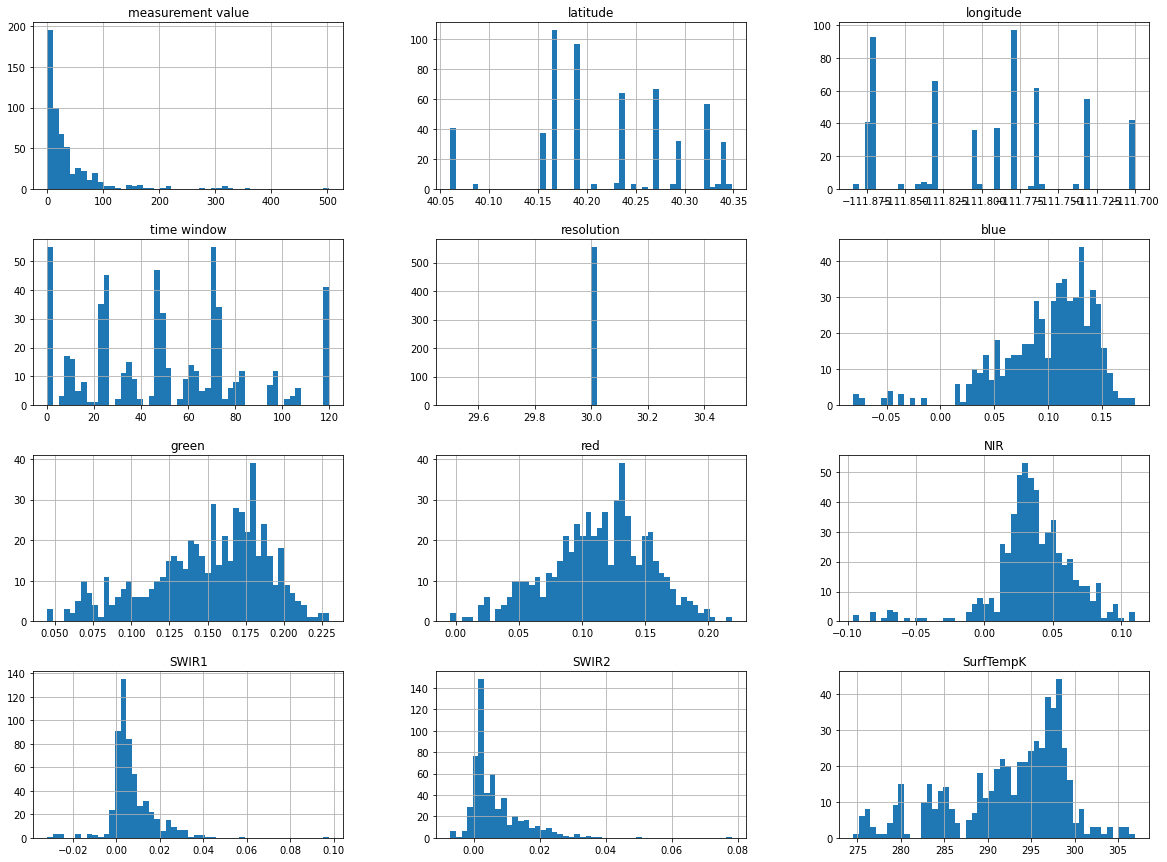

In [ ]:
df.head()                                         # look at the first five rows
df.info()                                         # get column info
df.describe()                                     # get column summary statistics
df.hist(bins=50,figsize=(20,15))                  # get a histogram for each column
plt.show()

# add a geographic point visualization

#### **Look at correlations**

In [ ]:
corr_matrix = df.corr()
corr_matrix['measurement value'].sort_values(ascending=False)

measurement value    1.000000
longitude            0.338242
SurfTempK            0.228669
NIR                  0.172381
time window          0.080955
SWIR1               -0.005450
SWIR2               -0.022264
latitude            -0.062185
red                 -0.336403
blue                -0.376202
green               -0.431479
resolution                NaN
Name: measurement value, dtype: float64

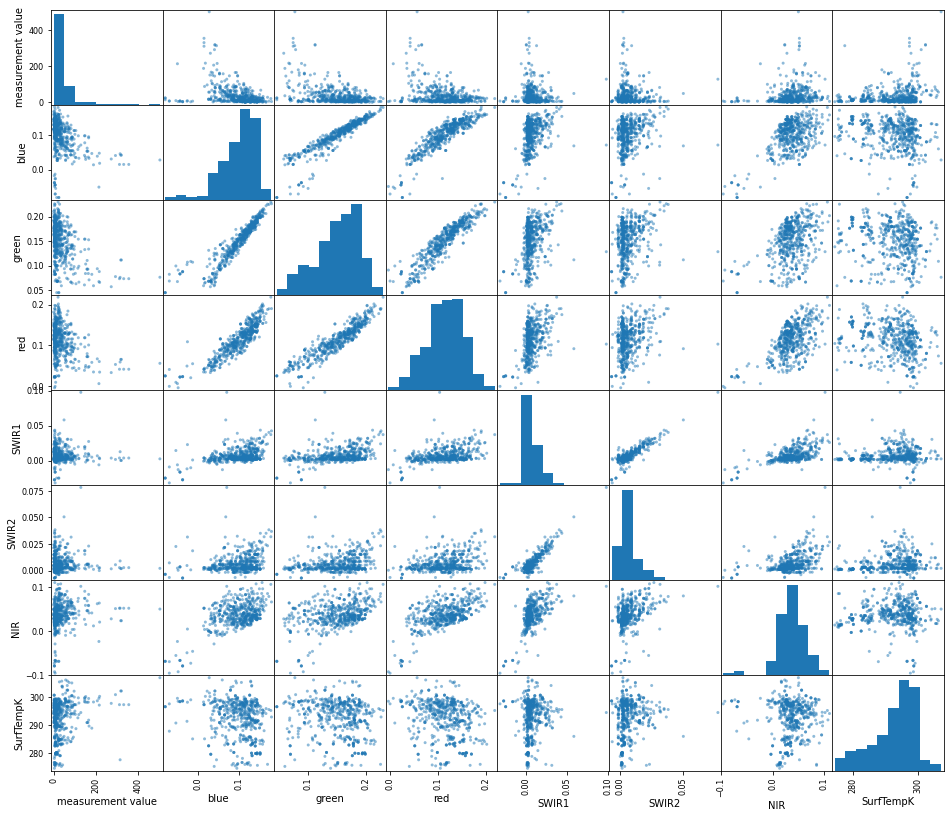

In [ ]:
attributes = ['measurement value','blue','green','red','SWIR1','SWIR2','NIR','SurfTempK']
scatter_matrix(df[attributes],figsize=(16,14));

### **Prepare data**

#### **Data cleaning**
This notebook assumes that you have done all desired data cleaning before importing the input CSV file. This may include removing duplicates, NANs, specifying minimum and maximum values, etc. We do, though, remove any rows with NANs to avoid errors.

In [ ]:
clean_df = df.copy()

# drop any rows with missing data
# or those outside the coincidence tolerance
# and reset index
clean_df[clean_df['time window'] > time_window] = np.nan
clean_df = clean_df.dropna().reset_index()

#### **Feature engineering**

In [ ]:
# function adds the logs for each
# specified column in the given data frame
def columnLogs(df,columns):
  new_df = df.copy()
  dummy_df = new_df.copy()

  # setting negative band values to 0.1
  for band in bands:
    dummy_df[band][dummy_df[band] <= 0.0] = 0.01

  for column in columns:
    logColumn = np.log(dummy_df[column])
    new_df['ln('+column+')'] = logColumn

  return new_df


# function adds the logs for each
# specified column in the given data frame
def columnInverseLogs(df,columns):
  new_df = df.copy()
  dummy_df = new_df.copy()

  # setting negative band values to 0.1
  for band in bands:
    dummy_df[band][dummy_df[band] <= 0.0] = 0.01

  for column in columns:
    inverse_log_column = 1 / np.log(dummy_df[column])
    new_df['1/ln('+column+')'] = inverse_log_column

  return new_df


# function adds the inverses for each
# specified column in the given data frame
def columnInverses(df,columns):
  new_df = df.copy()

  for column in columns:
    inverse_column = 1 /new_df[column]
    new_df['1/'+column] = inverse_column

  return new_df


# function adds the ratio combination of all
# specified columns in the given data frame
def columnsRatios(df,columns):
  new_df = df.copy()

  combs = list(it.combinations(columns, 2))

  for column1, column2 in combs:
    columns_ratio = new_df[column1] / new_df[column2]
    new_df['{0}/{1}'.format(column1, column2)] = columns_ratio

  return new_df


# function adds the normalized differences, uses combination
#  of all specified columns in the given data frame
def columnsNDs(df,columns):
  new_df = df.copy()
  
  combs = list(it.combinations(columns, 2))

  for column1, column2 in combs:
    columns_NDs = (new_df[column1] - new_df[column2])/(new_df[column1] + new_df[column2])
    new_df['{0}*{1}'.format(column1, column2)] = columns_NDs

  return new_df

# function adds the square of all specified
# columns in the given data frame
def columnSquares(df, columns):
  new_df = df.copy()

  for column in columns:
    column_square = new_df[column]**2
    new_df[column+'**2'] = column_square

  return new_df

# function adds the products of specified 
# columns in the given data frame (excluding squares)
def columnProducts(df, columns):
  new_df = df.copy()

  combs = list(it.combinations(columns, 2))

  for column1, column2 in combs:
    column_products = new_df[column1] * new_df[column2]
    new_df['{0}*{1}'.format(column1, column2)] = column_products
  
  return new_df

# dict of functions to tie user selections to
mod_lookup = {
    'ln(x)' : columnLogs,
    '1/ln(x)' : columnInverseLogs,
    '1/x' : columnInverses,
    'x1/x2': columnsRatios,
    '(x1-x2)/(x1_x2)' : columnsNDs,
    'x^2' : columnSquares,
    'x1*x2': columnProducts
}

### **Train Model**

In [ ]:
# get an initial x df by selecting bands
x = clean_df[bands]

# apply any band modifications to get all features
for i in range(len(mods)):
  function = mod_lookup[mods[i]]
  x = function(x,bands)

# get the y df of in situ measurement values only
y = clean_df['measurement value'].copy()

# combine the two dfs to get a full dataframe
# to export and model with, if desired
model_input = pd.concat([y, x], axis=1)

# take the log of the measurement value if specified
if log_prediction:
  y = np.log(y)

In [ ]:
# alternative model input genera
# # prepare model input df
# model_input = clean_df[bands]

# # apply any band modifications to get all features
# for i in range(len(mods)):
#   function = mod_lookup[mods[i]]
#   model_input = function(model_input,bands)

# model_input['ln(y)'] = np.log(model_input['measurement value'])

# # get x df by selecting bands
# x = model_input[bands]

# if log_prediction:
#   y = model_input['ln(y)']
# else:
#   y = model_input['measurement_value']

In [ ]:
random_state = 12883823

def kfoldError():
  train_errors = []
  test_errors = []

  rkf = RepeatedKFold(n_splits=n_splts, n_repeats=n_rpts, random_state=random_state) # generate k-fold index
  
  for train, test in rkf.split(x):
    x_test  = x.iloc[test]
    y_test  = y.iloc[test]
    x_train = x.iloc[train]
    y_train = y.iloc[train]

  model = Lasso(alpha, max_iter=1e9)
  model.fit(x_train,y_train)

  train_preds = model.predict(x_train)
  test_preds  = model.predict(x_test)

  # unlog all y's if specified
  if log_prediction:
    train_preds = np.exp(train_preds)
    test_preds  = np.exp(test_preds)
    y_test      = np.exp(y_test)  
    y_train     = np.exp(y_train)

  rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
  rmse_test  = np.sqrt(mean_squared_error(y_test, test_preds))

  train_errors.append(rmse_train)
  test_errors.append(rmse_test)

  avg_train_error = np.mean(train_errors)
  avg_test_error  = np.mean(test_errors)

  return [avg_train_error, avg_test_error]

In [ ]:
model = Lasso(alpha, max_iter=1e9) # LinearRegression()
model.fit(x, y);

#### **TXT result log export + plotting**

In [ ]:
def results():
  # TXT results
  timestamp = datetime.now().strftime("%m/%d/%Y %I:%M:%S %p %z UTC")

  file_name = datetime.now().strftime("model_%m.%d.%Y_%I.%M.%S.txt")

  parameters = model.feature_names_in_
  coefs = model.coef_
  coef_table = pd.DataFrame({'Parameters':parameters,
                            'Coefficients':coefs})
  coef_table[coef_table == 0.0] = np.nan
  coef_table = coef_table.dropna(axis=0)   # drop any rows with nans

  data_pairs = len(x.index)
  pixel_merging = df.loc[2, 'resolution']

  avg_train_rmse = kfoldError()[0]
  avg_test_rmse  = kfoldError()[1]

  def print_write(f,str):
    print(str)
    f.write(str)

  with open(file_name,'w') as f:
    print_write(f,'-------------------------------------------------------------------------------\n')
    print_write(f,'MODEL METADATA \n\n')

    print_write(f,'timestamp: ' + timestamp +' \n\n')

    print_write(f,'input file: ' + file_name_1 +' \n\n')

    print_write(f,'time-window: ± ' + str(time_window) + ' hours\n')
    print_write(f,'resolution: ' + str(pixel_merging) + ' m\n')
    print_write(f,'# of data pairs: ' + str(data_pairs) + '\n\n')
    
    print_write(f,'log prediction? ' + str(log_prediction) + '\n')
    print_write(f,'bands: ' + str(bands) + '\n')
    print_write(f,'band modifications: ' + str(mods) + '\n')
    print_write(f,'alpha: '+ str(alpha) + '\n\n')
    
    print_write(f,'-------------------------------------------------------------------------------\n')
    print_write(f,'MODEL \n\n')

    print_write(f,'# of features: ' + str(coef_table.shape[0]) + '\n\n')
    print_write(f,'intercept: ' + str(round(model.intercept_,3)) + '\n\n')
    print_write(f,coef_table.to_string(index=False) + '\n\n')

    print_write(f,'-------------------------------------------------------------------------------\n')
    print_write(f,'K-FOLD VALIDATION RESULTS \n\n')
    print_write(f,'# of splits: ' + str(n_splts) + '\n')
    print_write(f,'# of repeats: ' + str(n_rpts) + '\n\n')

    print_write(f,'Mean train RMSE: '+ str(round(avg_train_rmse,1)) + '\n')
    print_write(f,'Mean test RMSE: ' + str(round(avg_test_rmse,1)) + '\n\n')

    files.download(file_name)

  predictions = model.predict(x)   # use the model to predict the training data
  plt.scatter(y, predictions)      # plot the 

  plt.axis('square')
  plt.xlabel('measurement value', labelpad=10)
  plt.ylabel('predictions', labelpad=10)

  if log_prediction:
    plt.xlabel('ln(measurement value)', labelpad=10)
    plt.ylabel('ln(predictions)', labelpad=10)

## **Get Results**

-------------------------------------------------------------------------------

MODEL METADATA 


timestamp: 02/23/2023 05:57:15 PM  UTC 


input file: dataPairs_uncorrectedChla_30m_v03.csv 


time-window: ± 13.0 hours

resolution: 30 m

# of data pairs: 91


log prediction? False

bands: ['blue', 'green', 'red', 'NIR']

band modifications: ['ln(x)', '1/ln(x)', '1/x', 'x1/x2', '(x1-x2)/(x1_x2)', 'x^2', 'x1*x2']

alpha: 1


-------------------------------------------------------------------------------

MODEL 


# of features: 6


intercept: 117.85


Parameters  Coefficients
   ln(NIR)     23.635440
    1/blue      5.102399
   1/green    -15.832731
     1/red      6.259949
     1/NIR      0.010674
  blue/red    -20.140595


-------------------------------------------------------------------------------

K-FOLD VALIDATION RESULTS 


# of splits: 10

# of repeats: 20


Mean train RMSE: 16.2

Mean test RMSE: 17.6




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

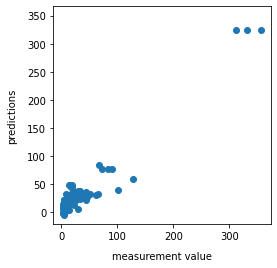

In [ ]:
results()

## **Export**

In [ ]:
#@markdown ### **Export model to CSV**

#@markdown This CSV file will include the model metadata 
#@markdown and the features with their coefficients. 

#@markdown Specify a file name (with *no* file extension):
file_name_2 = "model_v01" #@param {type:"string"}

parameters = model.feature_names_in_
coefs = model.coef_
coef_table = pd.DataFrame({'Parameters':parameters,
                          'Coefficients':coefs})
coef_table[coef_table == 0.0] = np.nan
coef_table = coef_table.dropna(axis=0)   # drop any rows with nans

coef_table.to_csv(file_name_2 + '.csv', index=False)

files.download(file_name_2 + '.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ### **Export model input CSV**

#@markdown This CSV file will include all *in situ* measurement values, 
#@markdown bands, and band modifications. 


#@markdown Specify a file name (with *no* file extension):
file_name_3 = "model_input_v01" #@param {type:"string"}

model_input.to_csv(file_name_3 + '.csv')
files.download(file_name_3 + '.csv')